<a href="https://colab.research.google.com/github/lsh3163/Cifar10Tutorial/blob/master/Cifar10Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homwerk2 : Neural Network 프레임워크로 구현

## 1. 데이터셋 준비

In [1]:
import torch
from torchvision import datasets, transforms
import helper

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# CUDA 기기가 존재한다면, 아래 코드가 CUDA 장치를 출력합니다:

print(device)

cuda:0


In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
# Download and load the training data
trainset = datasets.CIFAR10('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.CIFAR10('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

0it [00:00, ?it/s]

 99%|█████████▉| 168910848/170498071 [00:09<00:00, 20083976.70it/s]

Files already downloaded and verified


### Plot Image

In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

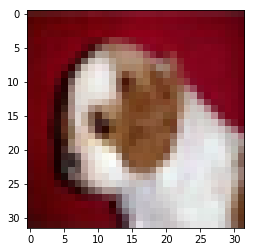

In [4]:
import matplotlib.pyplot as plt
import numpy as np
image, label = next(iter(trainloader))
imshow(image[0,:]);

## 2. 네트워크 만들기

In [0]:
from torch import nn
from torch import optim
from torch.nn import functional as F
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32*3, 512)
        self.batch1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.batch2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.batch3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 10)

        # 0.2정도를 무작위로 골라 dropout한다.
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(F.relu(self.batch1(self.fc1(x))))
        x = self.dropout(F.relu(self.batch2(self.fc2(x))))
        x = self.dropout(F.relu(self.batch3(self.fc3(x))))

        # output은 dropout하면 안된다..
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [6]:
model = Classifier()
model.to(device)
# Log Softmax Classifier
criterion = nn.NLLLoss()
# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.003, betas=(0.9, 0.999))

epochs=30
train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # 0으로 초기화
        optimizer.zero_grad()
        # log_ps-> 확률값
        log_ps = model(images.to(device))
        # 손실계산
        loss = criterion(log_ps, labels.to(device))
        loss.backward()
        optimizer.step()
        
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            # test 과정에 들어간다. dropout을 안하게 된다.
            # 정확하게 말하면, dropout 하는 비율이 0이 된다.
            model.eval()
            for images, labels in testloader:
                log_ps = model(images.to(device))
                test_loss += criterion(log_ps, labels.to(device))
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.to(device).view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        # 다시 트레이닝 과정으로 돌아간다.
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))


170500096it [00:20, 20083976.70it/s]                               

Epoch: 1/30..  Training Loss: 1.706..  Test Loss: 1.492..  Test Accuracy: 0.468
Epoch: 2/30..  Training Loss: 1.515..  Test Loss: 1.389..  Test Accuracy: 0.508
Epoch: 3/30..  Training Loss: 1.425..  Test Loss: 1.337..  Test Accuracy: 0.523
Epoch: 4/30..  Training Loss: 1.363..  Test Loss: 1.326..  Test Accuracy: 0.527
Epoch: 5/30..  Training Loss: 1.317..  Test Loss: 1.297..  Test Accuracy: 0.540
Epoch: 6/30..  Training Loss: 1.278..  Test Loss: 1.287..  Test Accuracy: 0.540
Epoch: 7/30..  Training Loss: 1.236..  Test Loss: 1.270..  Test Accuracy: 0.543
Epoch: 8/30..  Training Loss: 1.202..  Test Loss: 1.246..  Test Accuracy: 0.554
Epoch: 9/30..  Training Loss: 1.169..  Test Loss: 1.236..  Test Accuracy: 0.557
Epoch: 10/30..  Training Loss: 1.141..  Test Loss: 1.240..  Test Accuracy: 0.559
Epoch: 11/30..  Training Loss: 1.111..  Test Loss: 1.243..  Test Accuracy: 0.562
Epoch: 12/30..  Training Loss: 1.085..  Test Loss: 1.223..  Test Accuracy: 0.567
Epoch: 13/30..  Training Loss: 1.053.

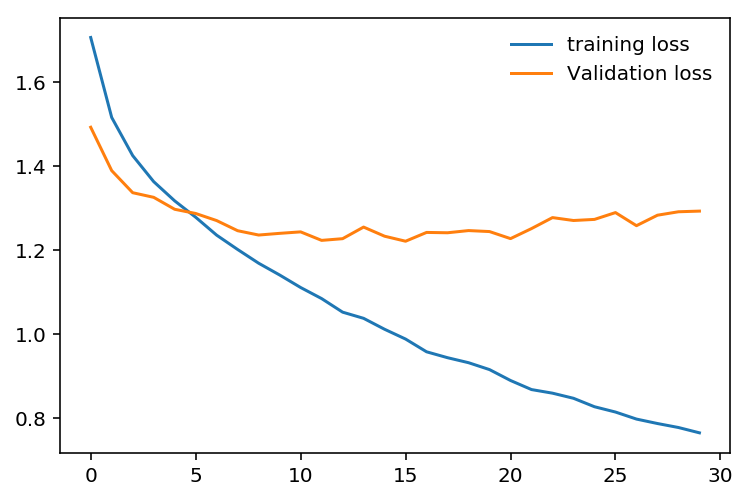

In [7]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Data Augmentation

In [8]:
!pip install git+https://github.com/aleju/imgaug
from imgaug import augmenters as iaa
import imgaug as ia

  Cloning https://github.com/aleju/imgaug to /tmp/pip-req-build-l3cov9yz
  Running command git clone -q https://github.com/aleju/imgaug /tmp/pip-req-build-l3cov9yz
     |████████████████████████████████| 20.0MB 40.3MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.9-cp36-none-any.whl size=820869 sha256=140fc10b2305222bb38c34615b9fc4bd57bf48d5d52bf24d898c545d2d86aa53
  Stored in directory: /tmp/pip-ephem-wheel-cache-bvw6e7qd/wheels/9c/f6/aa/41dcf2f29cc1de1da4ad840ef5393514bead64ac9e644260ff
Successfully built imgaug


In [0]:
class ImgAugTransform:
  def __init__(self):
    self.aug = iaa.Sequential([
        iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),
        iaa.Fliplr(0.5),
        iaa.Affine(rotate=(-20, 20), mode='symmetric'),
        iaa.Sometimes(0.25,
                      iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                                 iaa.CoarseDropout(0.1, size_percent=0.5)])),
        iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
    ])
      
  def __call__(self, img):
    img = np.array(img)
    return self.aug.augment_image(img)

aug_transforms = ImgAugTransform()

In [0]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([# transforms.RandomRotation(20),
                                aug_transforms,
                                transforms.ToTensor(),
                                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

In [14]:
# Download and load the training data
trainset = datasets.CIFAR10('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.CIFAR10('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
model = Classifier()
model.to(device)
# Log Softmax Classifier
criterion = nn.NLLLoss()
# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.003, betas=(0.9, 0.999))

epochs=30
train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # 0으로 초기화
        optimizer.zero_grad()
        # log_ps-> 확률값
        # Image를 GPU에 올리자
        log_ps = model(images.to(device))
        # 손실계산
        # labels를 GPU에 올리자
        loss = criterion(log_ps, labels.to(device))
        loss.backward()
        optimizer.step()
        
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            # test 과정에 들어간다. dropout을 안하게 된다.
            # 정확하게 말하면, dropout 하는 비율이 0이 된다.
            model.eval()
            for images, labels in testloader:
                log_ps = model(images.to(device))
                test_loss += criterion(log_ps, labels.to(device))
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.to(device).view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        # 다시 트레이닝 과정으로 돌아간다.
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))


Epoch: 1/30..  Training Loss: 1.761..  Test Loss: 1.585..  Test Accuracy: 0.433
Epoch: 2/30..  Training Loss: 1.604..  Test Loss: 1.487..  Test Accuracy: 0.472
Epoch: 3/30..  Training Loss: 1.550..  Test Loss: 1.456..  Test Accuracy: 0.482
Epoch: 4/30..  Training Loss: 1.511..  Test Loss: 1.428..  Test Accuracy: 0.491
Epoch: 5/30..  Training Loss: 1.479..  Test Loss: 1.395..  Test Accuracy: 0.499
Epoch: 6/30..  Training Loss: 1.460..  Test Loss: 1.378..  Test Accuracy: 0.511
Epoch: 7/30..  Training Loss: 1.437..  Test Loss: 1.359..  Test Accuracy: 0.512
Epoch: 8/30..  Training Loss: 1.419..  Test Loss: 1.332..  Test Accuracy: 0.526
Epoch: 9/30..  Training Loss: 1.406..  Test Loss: 1.331..  Test Accuracy: 0.521
Epoch: 10/30..  Training Loss: 1.392..  Test Loss: 1.321..  Test Accuracy: 0.529
Epoch: 11/30..  Training Loss: 1.384..  Test Loss: 1.303..  Test Accuracy: 0.534
Epoch: 12/30..  Training Loss: 1.373..  Test Loss: 1.303..  Test Accuracy: 0.532
Epoch: 13/30..  Training Loss: 1.369.

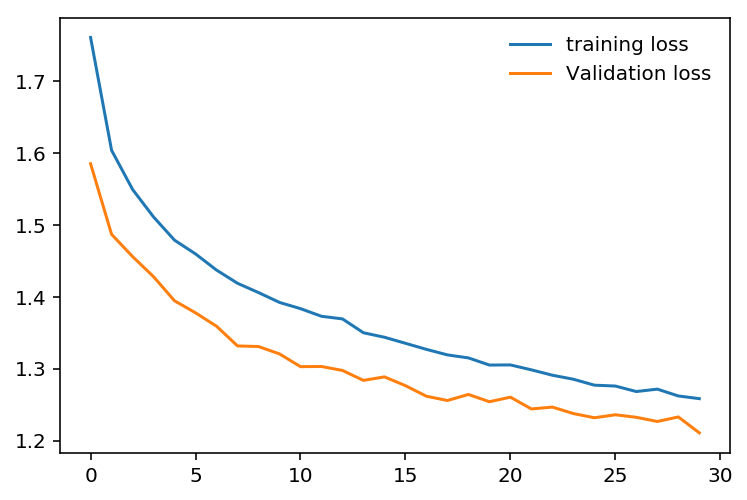

In [16]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)